In [10]:
import re
import os
import urllib.request
import getpass
from langchain.embeddings import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

In [2]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key: ········


In [ ]:
url = 'https://paulgraham.com/mit.html'
filename = 'pg_essay.txt'
urllib.request.urlretrieve(url, filename)

In [3]:
with open('pg_essay.txt') as file:
    essay = file.read()

In [4]:
single_sentences_list = re.split(r'(?<=[.?!])\s+', essay)
print (f"{len(single_sentences_list)} senteneces were found")

sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]

320 senteneces were found


In [5]:
sentences = sentences[1:]

In [6]:
def combine_sentences(sentences, buffer_size=1):
    for i in range(len(sentences)):
        combined_sentence = ''
        
        for j1 in range(i-buffer_size, i):
            if j1>=0:
                combined_sentence += sentences[j1]['sentence'] + ' '
        
        combined_sentence = sentences[i]['sentence']
        
        for j2 in range(i+1, i+1+buffer_size):
            if j2<len(sentences):
                combined_sentence += ' ' + sentences[j2]['sentence']
        
        sentences[i]['combined_sentence'] = combined_sentence
        
    return sentences

In [7]:
sentences = combine_sentences(sentences)

In [8]:
sentences[:3]

[{'sentence': '</font>\n<br><img src="http://www.virtumundo.com/images/spacer.gif" height=5 width=1></td\n></tr>\n</table>\n<p>\nOctober 2006<br /><br /><i>(This essay is derived from a talk at MIT.)</i><br /><br />Till recently graduating seniors had two choices: get a job or go\nto grad school.',
  'index': 1,
  'combined_sentence': '</font>\n<br><img src="http://www.virtumundo.com/images/spacer.gif" height=5 width=1></td\n></tr>\n</table>\n<p>\nOctober 2006<br /><br /><i>(This essay is derived from a talk at MIT.)</i><br /><br />Till recently graduating seniors had two choices: get a job or go\nto grad school. I think there will increasingly be a third option:\nto start your own startup.'},
 {'sentence': 'I think there will increasingly be a third option:\nto start your own startup.',
  'index': 2,
  'combined_sentence': "I think there will increasingly be a third option:\nto start your own startup. But how common will that be?<br /><br />I'm sure the default will always be to get a

In [9]:
openai_embeddings = OpenAIEmbeddings()

C:\Users\JackMiller\anaconda3\envs\LLM\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
embeddings = openai_embeddings.embed_documents([x['combined_sentence'] for x in sentences])

In [ ]:
with open('paul_graham_embeddings.pkl', 'wb') as pickle_file:
    pickle.dump(embeddings, pickle_file)

In [13]:
with open('paul_graham_embeddings.pkl', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [14]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [15]:
def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        distance = 1 - similarity
        distances.append(distance)
        sentences[i]['distance_to_next'] = distance

    return distances, sentences

In [16]:
distances, sentences = calculate_cosine_distances(sentences)

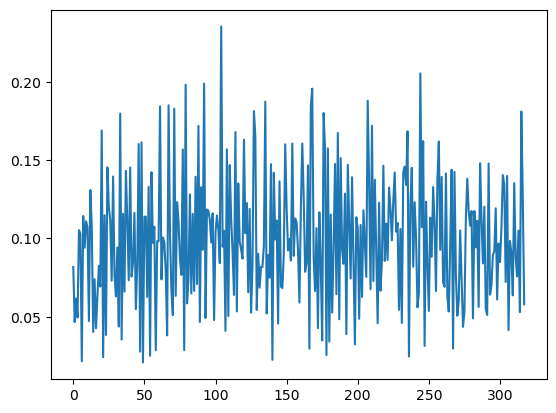

In [17]:
plt.plot(distances)

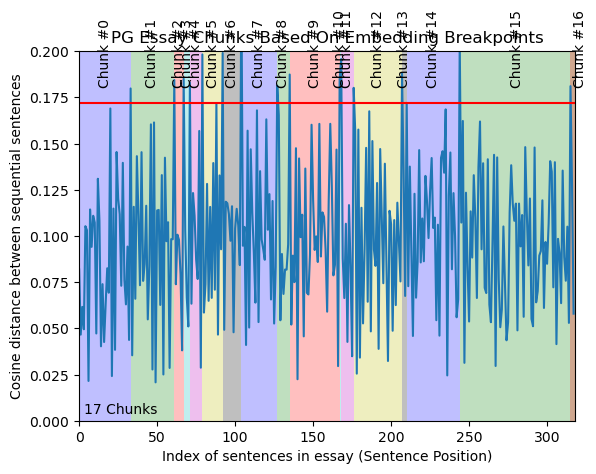

In [18]:
plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [19]:
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [20]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
</font>
<br><img src="http://www.virtumundo.com/images/spacer.gif" height=5 width=1></td
></tr>
</table>
<p>
October 2006<br /><br /><i>(This essay is derived from a talk at MIT.)</i><br /><br />Till
...
a week turns
out to be a good idea&mdash;but we've decided now
that the party line should be to tell people to wait till they
graduate.<br /><br />Does that mean you can't start a startup in college?


Chunk #1
Not at all. Sam Altman, the co-founder of <a href="http://loopt.com">Loopt</a>,
had just finished his sophomore year when we funded them, and Loopt
is probably the most promising of all the startups w
...
not sound like an advantage,
but it is a huge one. Poverty implies you can live cheaply,
and this is critically important for startups. Nearly every startup
that fails, fails by running out of money.


